In [2]:
import numpy as np
import pandas as pd
from pandas import DataFrame as df
import matplotlib.pyplot as plt
import matplotlib
import analysis_pca

Ts = 1000
data_path = r'C:\Users\IBS\Desktop\python_code_N2'
save_path = r'C:\Users\IBS\Desktop\figures'

In [3]:
#For FN angle averaged PCA

import pre_processing

ppss = pre_processing.pre_processing(Ts, data_path, save_path)
[final_cat, data_cat, val_cat, dur_cat, rejectedXY_cat] = ppss.datasorting_orientation(1)
apca = analysis_pca.analysis_pca(Ts, data_cat, save_path)
data_cat_sm = apca.smoothing_data()  # Smoothed data
data = np.mean(data_cat_sm, axis=0)  # Anagle averged data
PCA_total = apca.pca_analy(data)  # PCA

Wa = PCA_total['v'][:4]  # Wight matrix from angle averaged PCA

Dimensions: 1, Variance explained: 75.06%
Dimensions: 2, Variance explained: 85.13%
Dimensions: 3, Variance explained: 90.34%
Dimensions: 4, Variance explained: 93.95%
Dimensions: 5, Variance explained: 96.15%
Dimensions to be reduced: 3


In [4]:
#Multiply weight matrix (MWM) to each angle data

final_out = []
for a in range(8):
    out = Wa @ data_cat_sm[a]
    final_out.append(out)

final_out = np.array(final_out)

In [5]:
#Adjust MWM by subtract data point at -300 to -200ms

tmep_final = np.transpose(final_out,[2,0,1])
sTemplet = np.mean(tmep_final[:100], axis=0)
sTemplet = np.repeat(sTemplet[np.newaxis, :, :], 600, axis=0)
nfinal_out = np.transpose(tmep_final - sTemplet, [1, 2, 0])


#Adjust PCA by subtract data point at -300 to -200ms

tmep_final = PCA_total['p']
sTemplet = np.mean(tmep_final[:100], axis=0)
sTemplet = np.repeat(sTemplet[np.newaxis, :], 600, axis=0)
nPCA_out = tmep_final.T - sTemplet.T

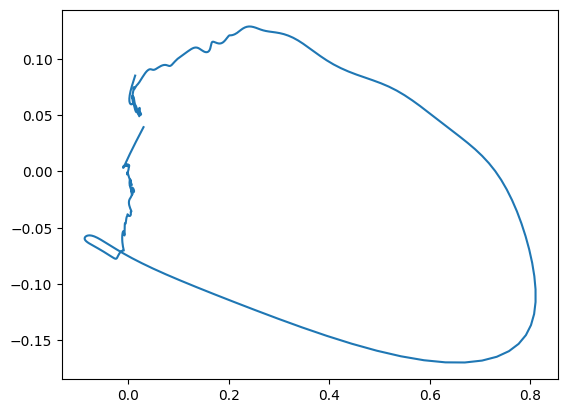

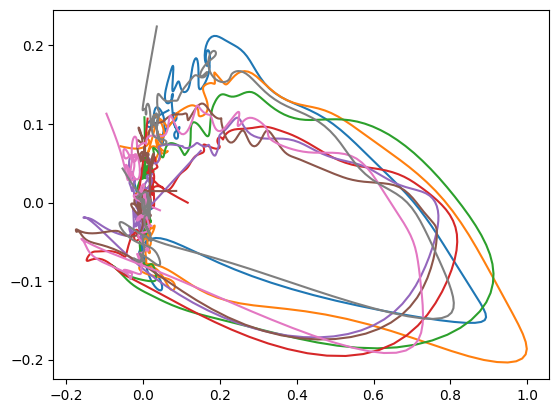

In [6]:
# Plotting

plt.figure()
plt.plot(nPCA_out[0], nPCA_out[1])

plt.figure()
for a in range(8):
    plt.plot(nfinal_out[a][0], nfinal_out[a][1])

Text(0.5, 0, '3D')

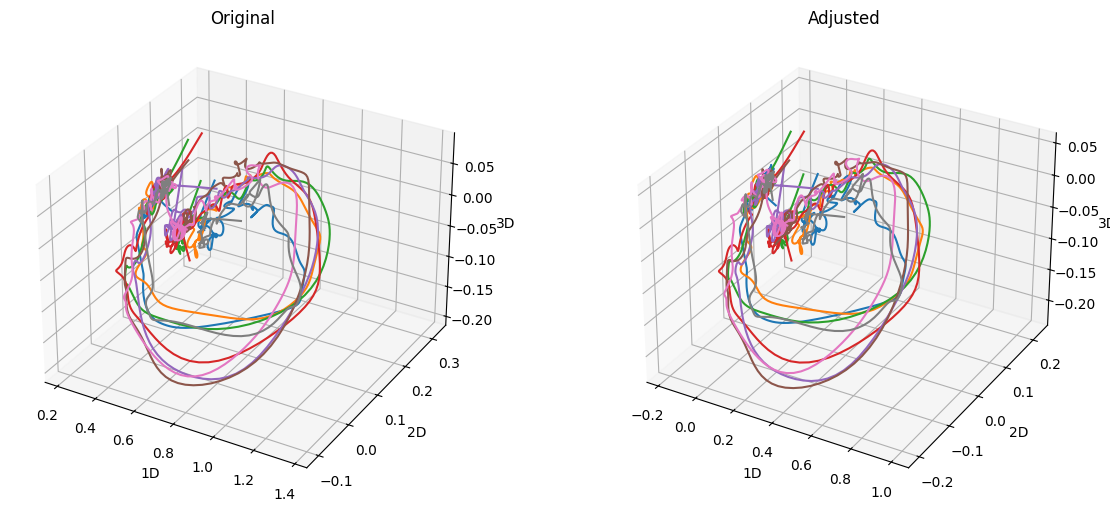

In [7]:
fig = plt.figure(constrained_layout=True,figsize=(12,5))
# subfigs = fig.subfigures(1, 2, wspace=0.07, width_ratios=[1, 1])

# 3D plot of original data

# subfigs[0].subplots(1, 1)
ax = fig.add_subplot(1, 2, 1, projection='3d')
for a in range(8):
    X = final_out[a, 0]; Y = final_out[a, 1]; Z = final_out[a, 2]
    ax.plot(X, Y, Z, label='parametric curve')
ax.set_title("Original")
ax.set_xlabel('1D'); ax.set_ylabel('2D'); ax.set_zlabel('3D')

# 3D plot of adjusted data

# subfigs[1].subplots(1, 1, projection='3d')
ax = fig.add_subplot(1, 2, 2, projection='3d')
# ax = plt.figure().add_subplot(projection='3d')
for a in range(8):
    X = nfinal_out[a, 0]; Y = nfinal_out[a, 1]; Z = nfinal_out[a, 2]
    ax.plot(X, Y, Z, label='parametric curve')
ax.set_title("Adjusted")
ax.set_xlabel('1D'); ax.set_ylabel('2D'); ax.set_zlabel('3D')

# ax.view_init(elev=0, azim=-120)

In [8]:
# Fitting

pca_p = nPCA_out[:4]
time = np.linspace(-300, 300, 600)

r_s_total = []
for a in range(8):
    resid = np.linalg.norm(pca_p - nfinal_out[a], axis=1)**2
    r_s = 1 - resid / (final_out[a].size * nfinal_out[a].var())
    r_s_total.append(r_s)

r_s_total = np.array(r_s_total)

Text(0.5, 1.0, 'direction=4, pc=0, R^2=0.9756770942464006')

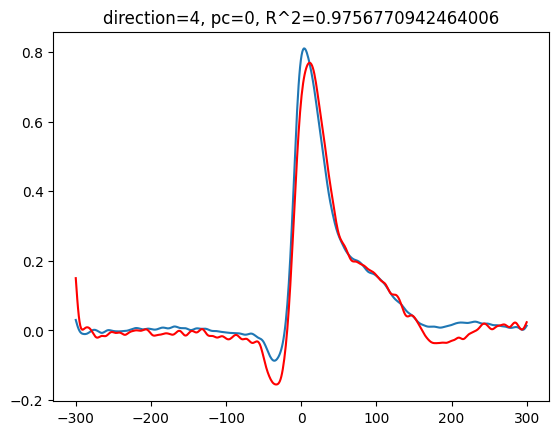

In [9]:
# Plotting

a = 4
b = 0

r_s = r_s_total[a][b]
plt.plot(time, pca_p[b], time, nfinal_out[a][b], 'r')
plt.title(f'direction={a}, pc={b}, R^2={r_s}')

## Onset delay

In [10]:
import numpy as np
import pandas as pd
from pandas import DataFrame as df
import matplotlib.pyplot as plt
import analysis_pca

Ts = 1000
data_path = r'C:\Users\IBS\Desktop\python_code_N2'
save_path = r'C:\Users\IBS\Desktop\figures'

import pre_processing

ppss = pre_processing.pre_processing(Ts, data_path, save_path)
[final_cat, data_cat, val_cat, dur_cat, rejectedXY_cat] = ppss.datasorting_orientation(1)

val_cat = np.array(val_cat)[:,:8]
data_cat = np.array(data_cat)[:, :8]

/home/jb/.venv/lib/python3.12/site-packages/sklearn/manifold/_mds.py:632: UserWarning: The MDS API has changed. ``fit`` now constructs an dissimilarity matrix from data. To use a custom dissimilarity matrix, set ``dissimilarity='precomputed'``.
  warnings.warn(


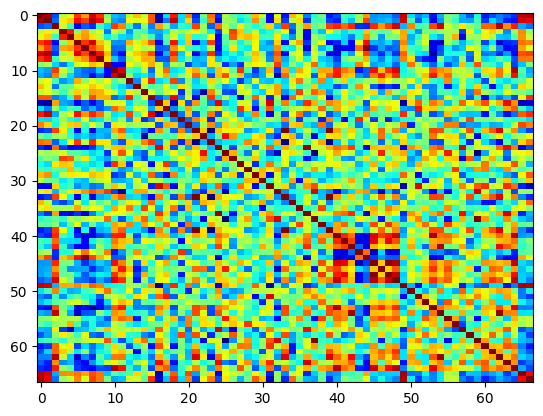

In [11]:
import preprecessing_distMat

pdm = preprecessing_distMat.preprecessing_distMat(Ts, data_cat, val_cat, save_path)
onset_delay = pdm.peak_delay(win=20)
p_t = pdm.peak_MDS(onset_delay, True)

(np.float64(-3.9303680645268764),
 np.float64(3.976401212126449),
 np.float64(-4.608530487613893),
 np.float64(5.543546924808362))

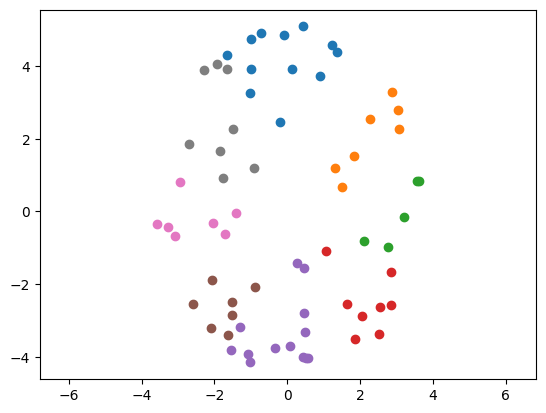

In [12]:
#Sorting cell by degree

from scipy.spatial import distance
from math import degrees

sp1 = np.argsort(p_t[:,1])[::-1][:5]
sp2 = np.argsort(np.abs(p_t[sp1, :][:, 0]))
sp = sp1[sp2[0]]

# p = p_t[sp]
cent = np.mean(p_t, axis=0)
p = [cent[0], cent[1] + 6]

deg_f = []
for a in range(len(p_t)):
    q = p_t[a]
    cos = 1-distance.cosine(p, q)
    deg = degrees(np.arccos(cos))
    if q[0] - p[0] < 0:
        deg = 360 - deg

    deg_f.append(deg)
deg_f = np.array(deg_f)

deg_idx = np.linspace(0, 360, 9) + 22.5
deg_idx = np.append(deg_idx[7], deg_idx[:7])

C_cat = []
for a in range(len(deg_idx)):
    if a == 0:
        C = np.where(np.logical_or(deg_f > deg_idx[a], deg_f <= deg_idx[a+1]))
    elif a == 7:
        C = np.where(np.logical_and(deg_f > deg_idx[a], deg_f <= deg_idx[0]))
    else:
        C = np.where(np.logical_and(deg_f > deg_idx[a], deg_f <= deg_idx[a+1]))
    C_cat.append(C)

# plotting
for a in range(8):
    plt.scatter(p_t[[C_cat[a]],0], p_t[[C_cat[a]],1])
plt.axis('equal')

In [13]:
C_cat

[(array([ 0,  1,  4,  5,  6,  7,  8, 15, 23, 29, 44, 66]),),
 (array([ 9, 13, 14, 28, 30, 32, 43]),),
 (array([19, 37, 50, 51, 59]),),
 (array([16, 24, 31, 36, 57, 58, 60, 63]),),
 (array([ 2, 10, 17, 21, 27, 33, 39, 40, 42, 53, 54, 62, 64]),),
 (array([11, 41, 45, 46, 47, 48, 61]),),
 (array([22, 25, 26, 38, 52, 55, 56]),),
 (array([ 3, 12, 18, 20, 34, 35, 49, 65]),)]

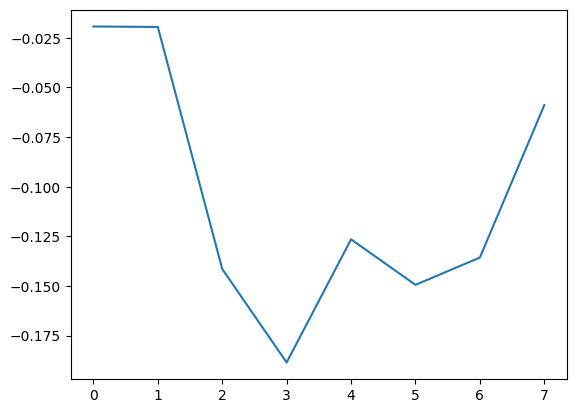

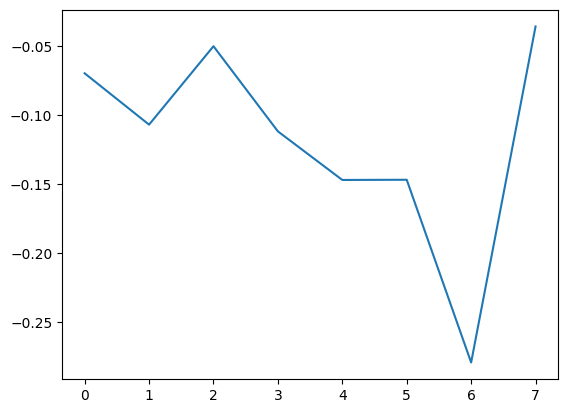

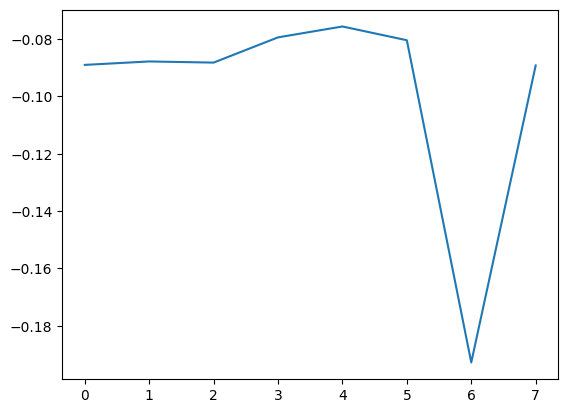

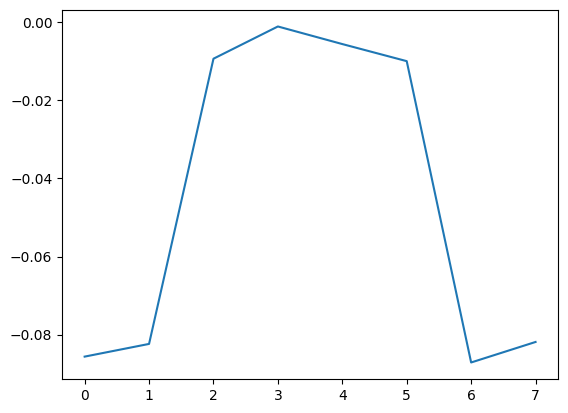

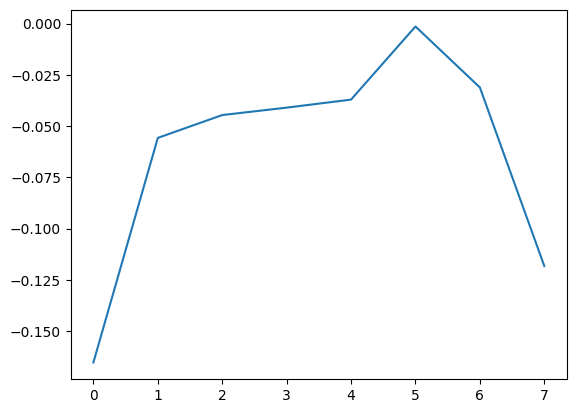

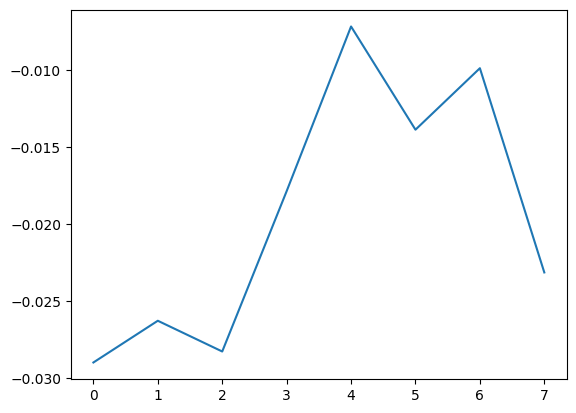

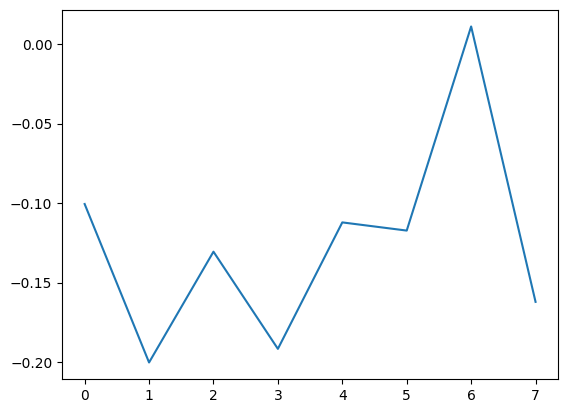

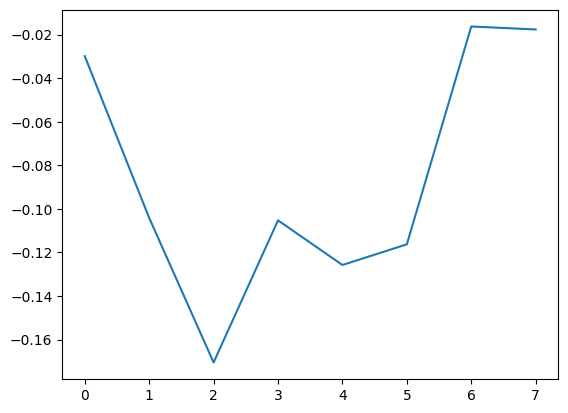

In [15]:
# Aligned data by latency

for a in range(8):
    plt.figure()
    plt.plot(np.mean(onset_delay[C_cat[a]], axis=0))



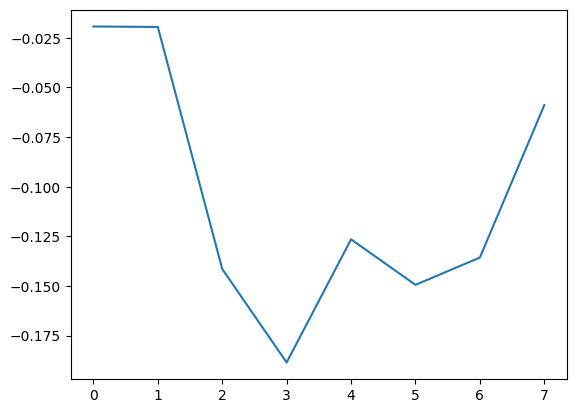

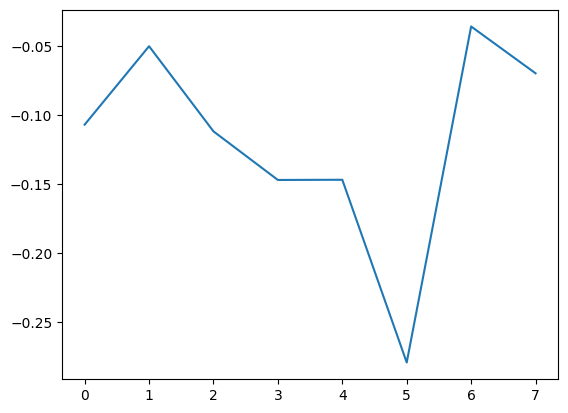

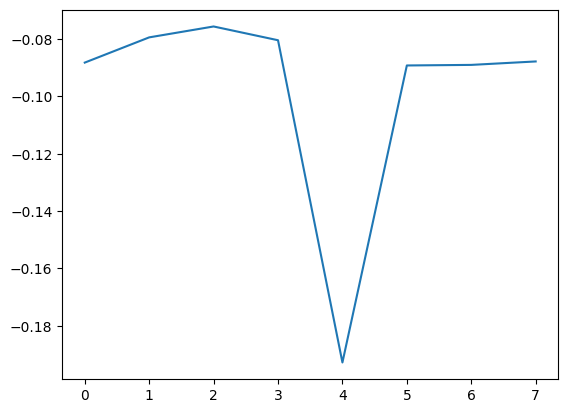

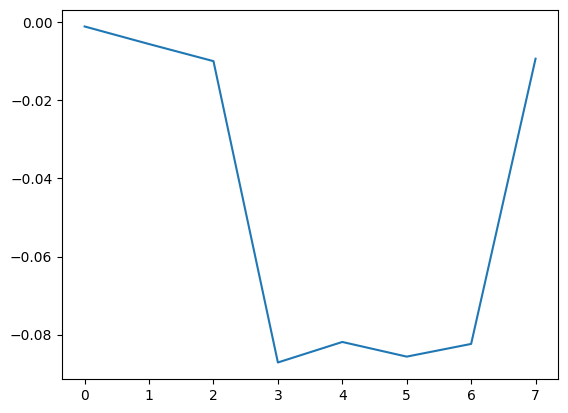

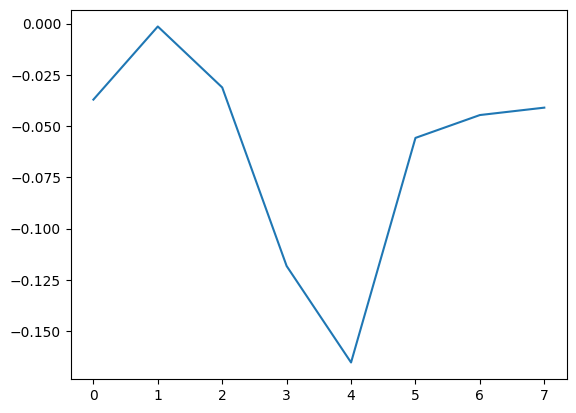

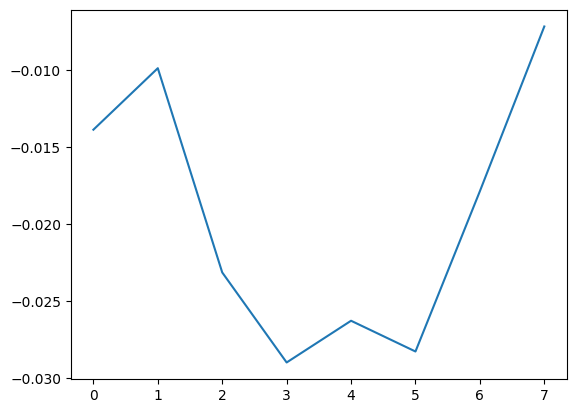

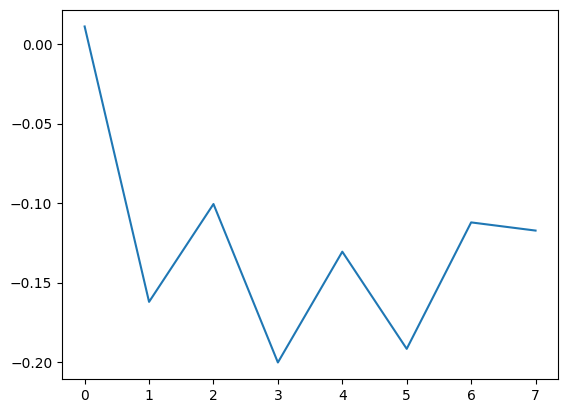

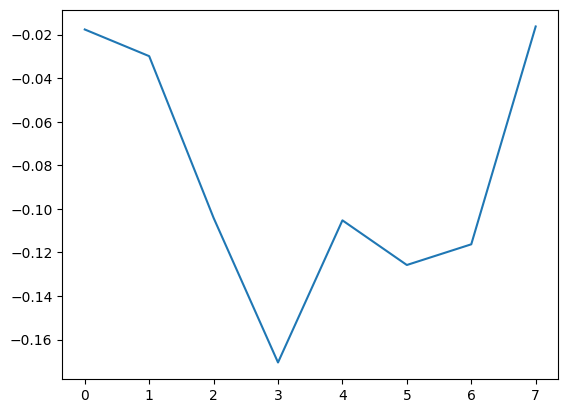

In [4]:
# Aligned data by latency

onset_delay_M = onset_delay[C_cat[0]]
for a in range(1,8):
    temp = onset_delay[C_cat[a]]
    temp2 = np.concat([temp[:,a:8], temp[:,:a]], axis=1)
    onset_delay_M = np.vstack([onset_delay_M, temp2])

idx_c =[0]
for a in range(8):
    idx_c.append(len(C_cat[a][0]))
idx_c = np.cumsum(idx_c)  

for a in range(8):
    plt.figure()
    plt.plot(np.mean(onset_delay_M[idx_c[a]:idx_c[a+1]], axis=0))

# Data align

data_cat2 = data_cat[C_cat[0]]
for a in range(1,8):
    temp = data_cat[C_cat[a]]
    temp2 = np.concat([temp[:,a:8], temp[:,:a]], axis=1)
    data_cat2 = np.vstack([data_cat2, temp2])

data_cat2 = np.hstack([data_cat2, data_cat2])  # put dummy for using analysis_pca code
data_cat2 = data_cat2[:,:9]

In [5]:
#For FN angle aligned PCA

apca = analysis_pca.analysis_pca(Ts, data_cat2, save_path)
data_cat_sm = apca.smoothing_data()  # Smoothed data
data = np.mean(data_cat_sm, axis=0)  # Anagle averged data
PCA_total = apca.pca_analy(data)  # PCA

Wa = PCA_total['v'][:4]  # Wight matrix from angle averaged PCA

Dimensions: 1, Variance explained: 75.06%
Dimensions: 2, Variance explained: 85.13%
Dimensions: 3, Variance explained: 90.34%
Dimensions: 4, Variance explained: 93.95%
Dimensions: 5, Variance explained: 96.15%
Dimensions to be reduced: 3


In [17]:
#For FN angle original PCA

data_cat = np.hstack([data_cat, data_cat])  # put dummy for using analysis_pca code
data_cat = data_cat[:,:9]
apca = analysis_pca.analysis_pca(Ts, data_cat, save_path)
data_cat_sm2 = apca.smoothing_data()  # Smoothed data
data2 = np.mean(data_cat_sm2, axis=0)  # Anagle averged data
PCA_total2 = apca.pca_analy(data2)  # PCA

Wa2 = PCA_total2['v'][:4]  # Wight matrix from angle averaged PCA

Dimensions: 1, Variance explained: 75.06%
Dimensions: 2, Variance explained: 85.13%
Dimensions: 3, Variance explained: 90.34%
Dimensions: 4, Variance explained: 93.95%
Dimensions: 5, Variance explained: 96.15%
Dimensions to be reduced: 3


In [18]:
#Multiply weight matrix (MWM) to each angle data

final_out = []
for a in range(8):
    out = Wa @ data_cat_sm[a]
    final_out.append(out)

final_out = np.array(final_out)

In [19]:
#Multiply weight matrix (MWM) to each angle data2 (original)

final_out2 = []
for a in range(8):
    out = Wa2 @ data_cat_sm2[a]
    final_out2.append(out)

final_out2 = np.array(final_out2)

In [7]:
#Adjust MWM by subtract data point at -300 to -200ms

tmep_final = np.transpose(final_out,[2,0,1])
sTemplet = np.mean(tmep_final[:100], axis=0)
sTemplet = np.repeat(sTemplet[np.newaxis, :, :], 600, axis=0)
nfinal_out = np.transpose(tmep_final - sTemplet, [1, 2, 0])


#Adjust PCA by subtract data point at -300 to -200ms

tmep_final = PCA_total['p']
sTemplet = np.mean(tmep_final[:100], axis=0)
sTemplet = np.repeat(sTemplet[np.newaxis, :], 600, axis=0)
nPCA_out = tmep_final.T - sTemplet.T

In [21]:
#Adjust MWM by subtract data point at -300 to -200ms (original)

tmep_final2 = np.transpose(final_out2,[2,0,1])
sTemplet2 = np.mean(tmep_final2[:100], axis=0)
sTemplet2 = np.repeat(sTemplet2[np.newaxis, :, :], 600, axis=0)
nfinal_out2 = np.transpose(tmep_final2 - sTemplet2, [1, 2, 0])


#Adjust PCA by subtract data point at -300 to -200ms (original)

tmep_final2 = PCA_total2['p']
sTemplet2 = np.mean(tmep_final2[:100], axis=0)
sTemplet2 = np.repeat(sTemplet2[np.newaxis, :], 600, axis=0)
nPCA_out2 = tmep_final2.T - sTemplet2.T

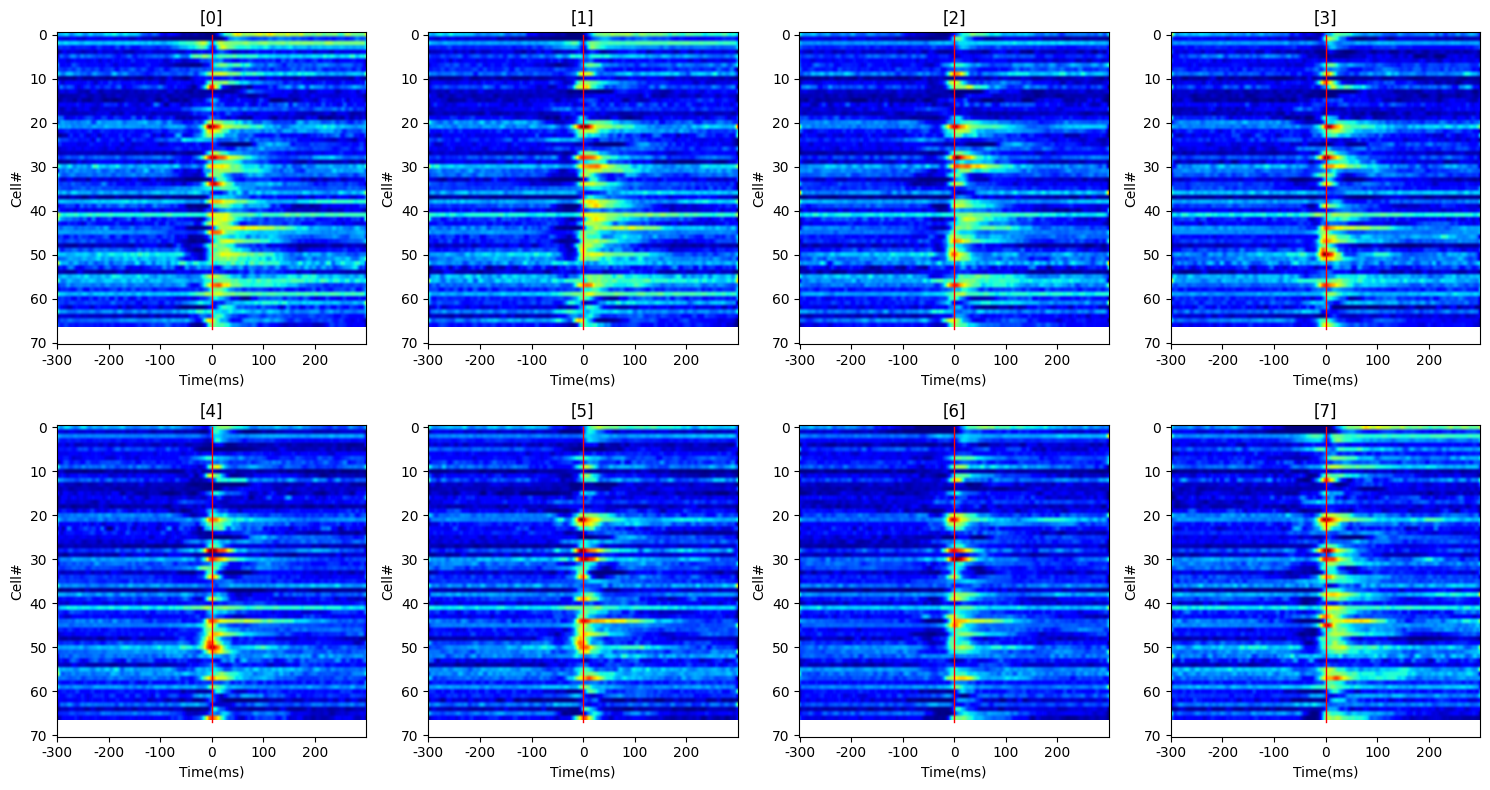

In [8]:
# Plotting raw data of each orientation
# label_ori = ['Up', 'Up right', 'Right', 'Down right',
#              'Down', 'Down left', 'Left', 'Up left']

fig, axes = plt.subplots(2, 4, figsize=(15, 8))

c = 0
for a in range(8):
# for a in [2, 1, 0, 7, 6, 5, 4, 3]: # right to down right, anticlock-wise
    ax = axes[a // 4, a % 4]  # Determine the subplot location
    ax.imshow(data_cat_sm[a], aspect='auto', cmap='jet', origin='upper')  # Display the data
    ax.plot([300, 300], [0, len(data_cat_sm[0])], 'r', linewidth=1)  # Red vertical line
    ax.set_xticks(np.arange(0, 600, 100))  # Set X ticks
    ax.set_xticklabels(np.arange(-300, 300, 100))  # Set X tick labels
    # ax.set_title(label_ori[c])  # Set the title for each subplot
    ax.set_title([c])  # Set the title for each subplot
    ax.set_ylabel("Cell#")  # Set Y-axis label
    ax.set_xlabel("Time(ms)")  # Set X-axis label
    c = c + 1

plt.tight_layout()

plt.savefig('raw.jpg', dpi=300)
plt.show()

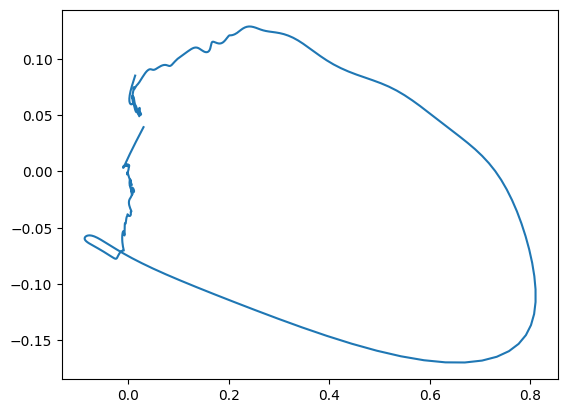

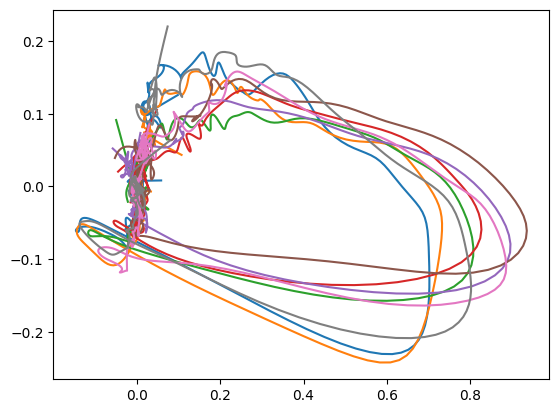

In [9]:
# Plotting

plt.figure()
plt.plot(nPCA_out[0], nPCA_out[1])

plt.figure()
for a in range(8):
    plt.plot(nfinal_out[a][0], nfinal_out[a][1])

Text(0.5, 0, '3D')

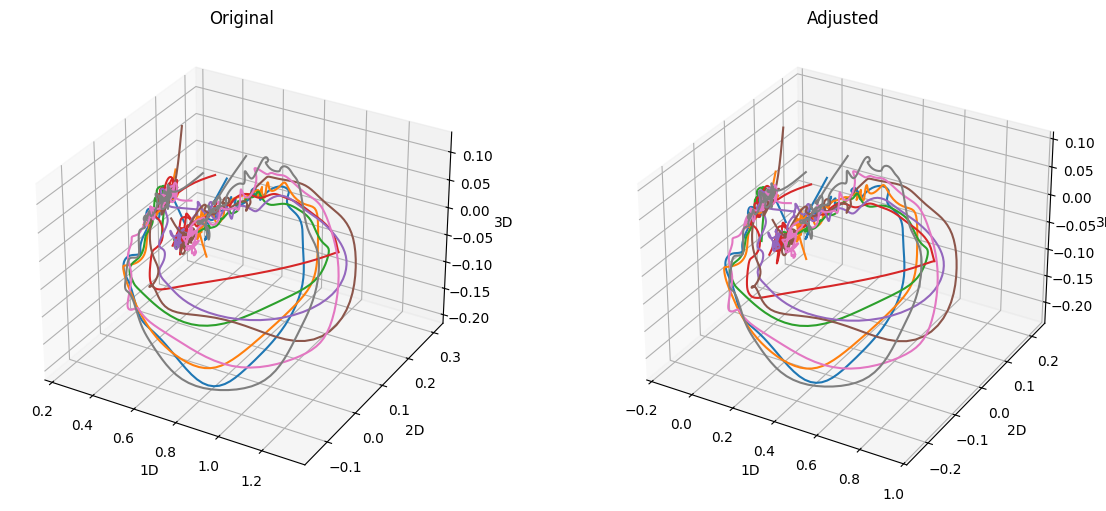

In [10]:
fig = plt.figure(constrained_layout=True,figsize=(12,5))
# subfigs = fig.subfigures(1, 2, wspace=0.07, width_ratios=[1, 1])

# 3D plot of original data

# subfigs[0].subplots(1, 1)
ax = fig.add_subplot(1, 2, 1, projection='3d')
for a in range(8):
    X = final_out[a, 0]; Y = final_out[a, 1]; Z = final_out[a, 2]
    ax.plot(X, Y, Z, label='parametric curve')
ax.set_title("Original")
ax.set_xlabel('1D'); ax.set_ylabel('2D'); ax.set_zlabel('3D')

# 3D plot of adjusted data

# subfigs[1].subplots(1, 1, projection='3d')
ax = fig.add_subplot(1, 2, 2, projection='3d')
# ax = plt.figure().add_subplot(projection='3d')
for a in range(8):
    X = nfinal_out[a, 0]; Y = nfinal_out[a, 1]; Z = nfinal_out[a, 2]
    ax.plot(X, Y, Z, label='parametric curve')
ax.set_title("Adjusted")
ax.set_xlabel('1D'); ax.set_ylabel('2D'); ax.set_zlabel('3D')

# ax.view_init(elev=0, azim=-120)

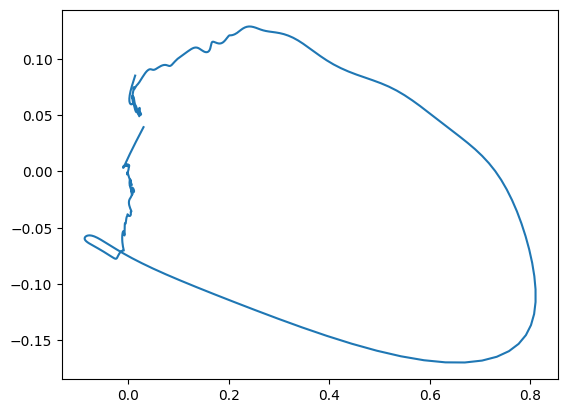

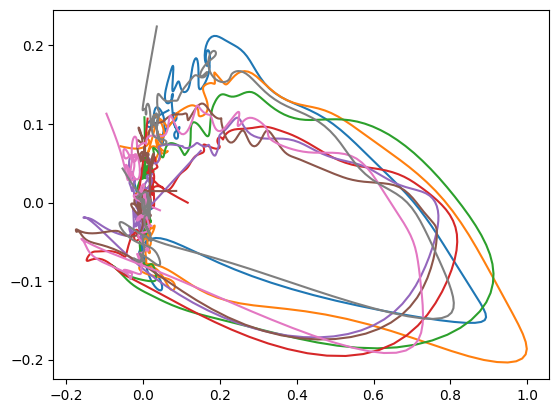

In [23]:
# Plotting (angle original)

plt.figure()
plt.plot(nPCA_out2[0], nPCA_out2[1])

plt.figure()
for a in range(8):
    plt.plot(nfinal_out2[a][0], nfinal_out2[a][1])

Text(0.5, 0, '3D')

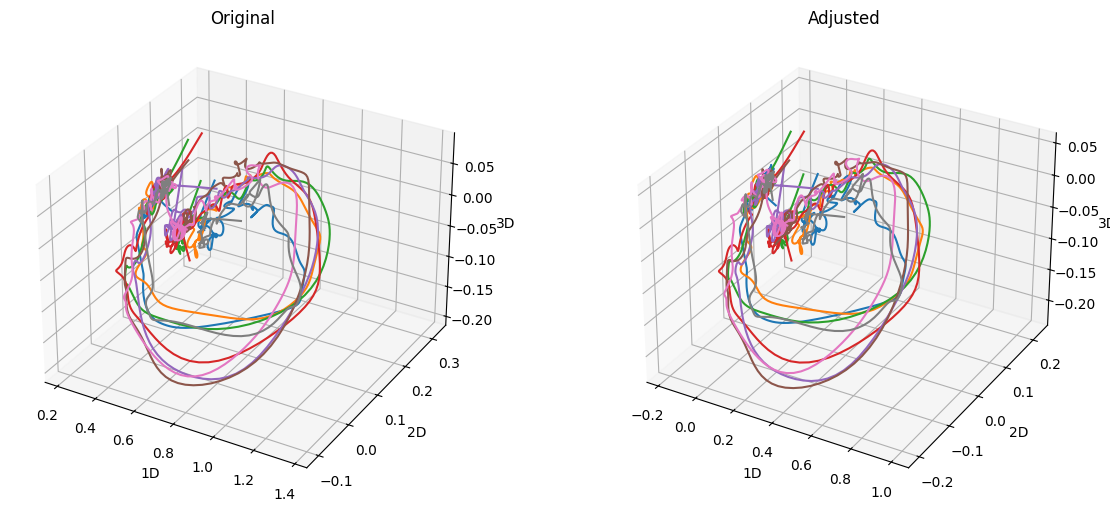

In [24]:
# original

fig = plt.figure(constrained_layout=True,figsize=(12,5))
# subfigs = fig.subfigures(1, 2, wspace=0.07, width_ratios=[1, 1])

# 3D plot of original data

# subfigs[0].subplots(1, 1)
ax = fig.add_subplot(1, 2, 1, projection='3d')
for a in range(8):
    X = final_out2[a, 0]; Y = final_out2[a, 1]; Z = final_out2[a, 2]
    ax.plot(X, Y, Z, label='parametric curve')
ax.set_title("Original")
ax.set_xlabel('1D'); ax.set_ylabel('2D'); ax.set_zlabel('3D')

# 3D plot of adjusted data

# subfigs[1].subplots(1, 1, projection='3d')
ax = fig.add_subplot(1, 2, 2, projection='3d')
# ax = plt.figure().add_subplot(projection='3d')
for a in range(8):
    X = nfinal_out2[a, 0]; Y = nfinal_out2[a, 1]; Z = nfinal_out2[a, 2]
    ax.plot(X, Y, Z, label='parametric curve')
ax.set_title("Adjusted")
ax.set_xlabel('1D'); ax.set_ylabel('2D'); ax.set_zlabel('3D')

# ax.view_init(elev=0, azim=-120)

In [ ]:
temp_PC = PCA_total2['p'].T

s_temp1 = gaussian_filter1d(temp_PC[0], win)
s_temp2 = gaussian_filter1d(temp_PC[1], win)
s_temp3 = gaussian_filter1d(temp_PC[2], win)

X = s_temp1[0:600]
Y = s_temp2[0:600]
Z = s_temp3[0:600]

# plt.scatter(X, Y, s=10, color = [0, 0, 0], marker='o')
plt.plot(X, Y, linewidth=3.0, color = [0, 0, 0])
plt.scatter(X[0], Y[0], s=400, color = [0, 0, 0], facecolors='none')
plt.scatter(X[300], Y[300], marker=CARETUP, s=200, color = [0, 0, 0], facecolor = [0.2, 0.2, 0.2])
plt.xlabel('dPC1')
plt.ylabel('dPC2')

In [77]:
from matplotlib.animation import FuncAnimation

def run(frame_number):
    axs[0].view_init(azim=225 + frame_number*2)
    axs[1].view_init(azim=225 + frame_number*2)

# animation
anim = FuncAnimation(ax, run, frames=180, interval=5)

ax.show()

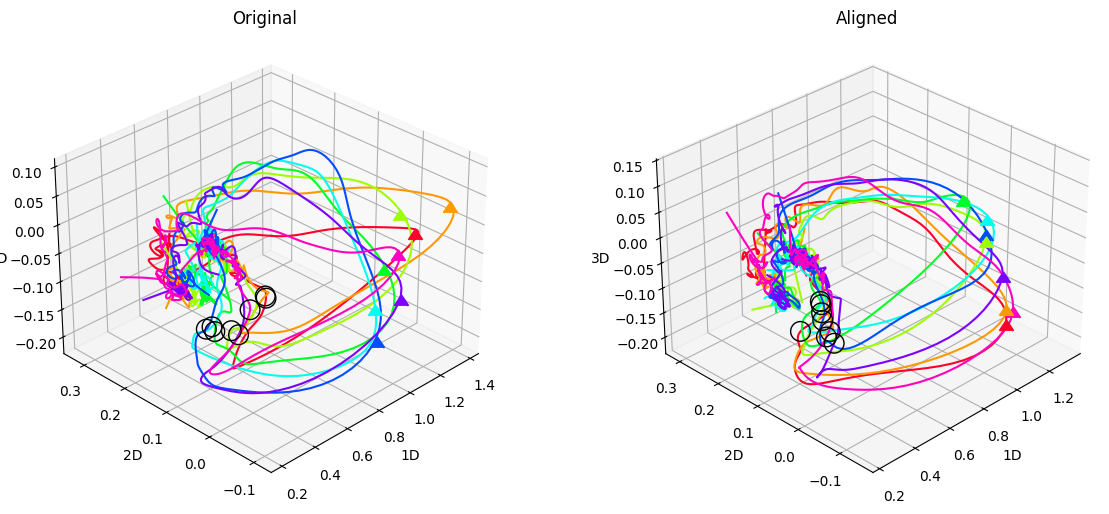

In [90]:
# Pretty figure

from matplotlib.markers import CARETUP
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

# color map
cmap = matplotlib.colormaps.get_cmap("gist_rainbow")
C_list = cmap( np.linspace(0.0, 1.0, 8) ) # extract 20 colors from cmap

fig = plt.figure(constrained_layout=True,figsize=(12,5))
# subfigs = fig.subfigures(1, 2, wspace=0.07, width_ratios=[1, 1])

# 3D plot of angle original data

# subfigs[0].subplots(1, 1)
ax = fig.add_subplot(1, 2, 1, projection='3d')
for a in range(8):
    X = final_out2[a, 0]; Y = final_out2[a, 1]; Z = final_out2[a, 2]
    ax.plot(X, Y, Z, label='parametric curve', color = C_list[a])
    ax.scatter(X[250], Y[250], Z[250], s=200, color = [0, 0, 0], facecolors='none')
    ax.scatter(X[300], Y[300], Z[300], marker=CARETUP, s=100, color = C_list[a], facecolor = C_list[a])
ax.set_title("Original")
ax.set_xlabel('1D'); ax.set_ylabel('2D'); ax.set_zlabel('3D')


# 3D plot of angle aligned data

# subfigs[0].subplots(1, 1)
ax2 = fig.add_subplot(1, 2, 2, projection='3d')
for a in range(8):
    X = final_out[a, 0]; Y = final_out[a, 1]; Z = final_out[a, 2]
    ax2.plot(X, Y, Z, label='parametric curve', color = C_list[a])
    ax2.scatter(X[250], Y[250], Z[250], s=200, color = [0, 0, 0], facecolors='none')
    ax2.scatter(X[300], Y[300], Z[300], marker=CARETUP, s=100, color = C_list[a], facecolor = C_list[a])
ax2.set_title("Aligned")
ax2.set_xlabel('1D'); ax2.set_ylabel('2D'); ax2.set_zlabel('3D')

# animation
def run(frame_number):
    ax.view_init(azim=225 + frame_number*2)
    ax2.view_init(azim=225 + frame_number*2)

anim = FuncAnimation(fig, run, frames=180, interval=20)

# HTML(anim.to_jshtml())
# plt.show()

In [11]:
# Fitting

pca_p = nPCA_out[:4]
time = np.linspace(-300, 300, 600)

r_s_total = []
for a in range(8):
    resid = np.linalg.norm(pca_p - nfinal_out[a], axis=1)**2
    r_s = 1 - resid / (final_out[a].size * nfinal_out[a].var())
    r_s_total.append(r_s)

r_s_total = np.array(r_s_total)

Text(0.5, 1.0, 'direction=1, pc=0, R^2=0.969571670442391')

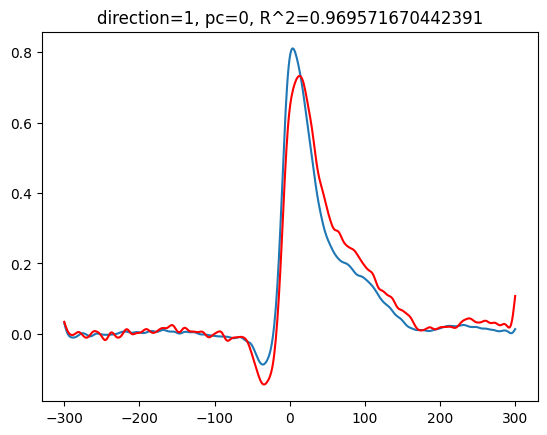

In [12]:
# Plotting

a = 1
b = 0

r_s = r_s_total[a][b]
plt.plot(time, pca_p[b], time, nfinal_out[a][b], 'r')
plt.title(f'direction={a}, pc={b}, R^2={r_s}')

In [9]:
# a=24
# t = np.arange(-250,250)
# plt.plot(t, pFN[a], t, pMPC @ betas[a], 'r')
# resid = np.linalg.norm(pMPC @ betas[a] - pFN[a])**2
# r_s = 1 - resid / (pFN[a].size * pFN[a].var())`a
# plt.title(f'a={a}, R^2={r_s}')

NameError: name 'pFN' is not defined